# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**: Bor-Jiun Tseng, Rishi

**ID**:Bt366, Rrv25

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\nobel\OneDrive\桌面\BEE5750\hw\hw5-rishi`
Precompiling project...
  ✓ EpollShim_jll
  ✓ Libmount_jll
  ✓ Xorg_libXau_jll
  ✓ Xorg_libXdmcp_jll
  ✓ Xorg_xtrans_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ gperf_jll
  ✓ XSLT_jll
  ✓ Interpolations → InterpolationsUnitfulExt
  ✓ Latexify
  ✓ Xorg_libX11_jll
  ✓ HTTP
  ✓ Latexify → DataFramesExt
  ✓ UnitfulLatexify
  ✓ Plots → UnitfulExt
  15 dependencies successfully precompiled in 24 seconds. 218 already precompiled.


In [2]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

In [3]:

waste_model = Model(HiGHS.Optimizer)

#Decision Variables

I = 1:3
#1=city 1
#2=city 2
#3=city 3
J = 1:3
#1=LF
#2=MRF
#3=WTE
K = 1:3
#1=LF
#2= MRF
#3 = WTE

@variable(waste_model, w[i in I, j in J] >=0)
@variable(waste_model, r[k in K, j in J] >=0)
@variable(waste_model, Y[j in J], Bin)


#Costs

#WTE Costs

WTE_Costs = 2500*Y[3] + 60*(w[1,3]+w[2,3]+w[3,3]+r[2,3])

#MRF Costs

MRF_Costs = 1500*Y[2] + 7*(w[1,2]+w[2,2]+w[3,2]) + 40(.4(w[1,2]+w[2,2]+w[3,2]))

#LF Costs

LF_Costs = 2000*Y[1] + 50*(w[1,1]+w[2,1]+w[3,1] + r[2,1] + r[3,1]) 

Trans_Costs = 1.5(5*w[1,1]+30*w[1,2]+15*w[1,3]+15*w[2,1]+25*w[2,2]+10*w[2,3]+13*w[3,1]+45*w[3,2]+20*w[3,3])

Total_Cost = Trans_Costs + WTE_Costs + MRF_Costs + LF_Costs
@objective(waste_model, Min, Total_Cost);
#Constraints

#Disposal Constraints
@constraint(waste_model, WTE_Limit, w[1,3]+ w[2,3] + w[3,3] + r[2,3] <= 210)
@constraint(waste_model, MRF_Limit, w[1,2] + w[2,2] + w[3,2] <= 350)
@constraint(waste_model, LF_Limit, w[1,1]+ w[2,1] + w[3,1] + r[2,1] + r[3,1] <= 200)

#City Mass Balance Constraints
@constraint(waste_model, city_1, w[1,1]+ w[1,2] + w[1,3] == 100)
@constraint(waste_model, city_2, w[2,1] + w[2,2] + w[2,3] == 90)
@constraint(waste_model, city_3, w[3,1]+ w[3,2] + w[3,3] == 120)

#Residual Ash Mass-Balance Constraints
@constraint(waste_model, recycled_ash_flow, r[2,3] == .14(.6*(w[1,2]+w[2,2] + w[3,2])))
@constraint(waste_model, total_ash_flow, r[3,1] == .16(w[1,3] + w[2,3] + w[3,3]) + r[2,3])
@constraint(waste_model, nonrecycled_flow, r[2,1] +r[2,3] == .6(w[1,2] + w[2,2] + w[3,2]))

M=10000
#Indicator Contraints

@constraint(waste_model,w[1,2]+ w[2,2] + w[3,2]  <= M* Y[2])
@constraint(waste_model, w[1,1]+ w[2,1] + w[3,1] + r[2,1] + r[3,1] <= M*Y[1])
@constraint(waste_model,w[1,3]+ w[2,3] + w[3,3] + r[2,3] <= M* Y[3])


optimize!(waste_model)


Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [8e-02, 1e+04]
  Cost   [5e+01, 2e+03]
  Bound  [1e+00, 1e+00]
  RHS    [9e+01, 4e+02]
Presolving model
11 rows, 15 cols, 47 nonzeros  0s
9 rows, 13 cols, 51 nonzeros  0s
7 rows, 10 cols, 31 nonzeros  0s
6 rows, 10 cols, 25 nonzeros  0s

Solving MIP model with:
   6 rows
   10 cols (1 binary, 0 integer, 0 implied int., 9 continuous)
   25 nonzeros
MIP-Timing:      0.0047 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol  

In [4]:
println("Optimal objective value: ", round(objective_value(waste_model); digits = 2))

println("W values:")
for i in 1:3
    for j in 1:3
        println("W[", i, ",", j, "] = ", round(value(w[i, j]); digits = 2))
    end
end

println("R values:")
for i in 1:3
    for j in 1:3
        println("R[", i, ",", j, "] = ", round(value(r[i, j]); digits = 2))
    end
end

Optimal objective value: 27227.14
W values:
W[1,1] = 100.0
W[1,2] = 0.0
W[1,3] = 0.0
W[2,1] = -0.0
W[2,2] = 0.0
W[2,3] = 90.0
W[3,1] = 79.05
W[3,2] = 0.0
W[3,3] = 40.95
R values:
R[1,1] = 0.0
R[1,2] = 0.0
R[1,3] = 0.0
R[2,1] = 0.0
R[2,2] = 0.0
R[2,3] = 0.0
R[3,1] = 20.95
R[3,2] = 0.0
R[3,3] = 0.0


Given these factors, the model avoids using MRF since:

Sending waste directly to LF or WTE is more cost-effective.
LF and WTE can handle the entire waste stream within their capacities.
- Yes, the solution make sense because the objective is cost minimization:
The optimization model is designed to minimize total costs, and avoiding MRF reduces both fixed and variable costs.
Since LF and WTE have sufficient capacity to process all waste and ash.
- Second reason is that cities are closer to LF and WTE compared to MRF, reducing transportation expenses.

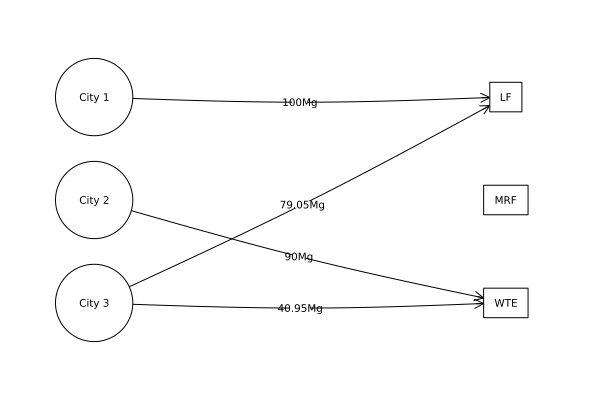

In [7]:
using GraphRecipes
using Plots

# Adjacency matrix
A = [
    0 0 0 1 0 0;  # City 1 -> LF
    0 0 0 0 0 1;  # City 2 -> WTE
    0 0 0 1 0 1;  # City 3 -> LF, WTE
    0 0 0 0 0 0; 
    0 0 0 0 0 0;  
    0 0 0 0 0 0   
]

# Node names
names = ["City 1", "City 2", "City 3", "LF", "MRF", "WTE"]

# Edge labels
edge_labels = Dict(
    (1, 4) => "100Mg",
    (2, 6) => "90Mg",
    (3, 4) => "79.05Mg",
    (3, 6) => "40.95Mg"
)

# Node shapes
shapes = [:circle, :circle, :circle, :rect, :rect, :rect]

# Node positions
xpos = [-2, -2, -2, 2, 2, 2]
ypos = [2, 1, 0, 2, 1, 0]

# Plot the graph
p = graphplot(
    A,
    names=names,
    edgelabel=edge_labels,
    markersize=0.4,
    markershapes=shapes,
    markercolor=:white,
    x=xpos,
    y=ypos,
    arrow=true,  # Enable arrows
    linecolor=:black  # Edge color
)

# Display the plot
display(p)

## References

List any external references consulted, including classmates.